<a href="https://colab.research.google.com/github/Dhingraakshat/Fraud-detection/blob/main/Base_Models/V39(ISOLATION_FOREST).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# If running in Google Colab, uncomment:
!pip -q install optuna shap scikit-learn

import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    precision_recall_curve,
    recall_score, precision_score, f1_score,
    roc_auc_score, average_precision_score,
    classification_report, ConfusionMatrixDisplay
)
import optuna
import shap

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 12.7 MB/s eta 0:00:00


In [ ]:
# Mount if in Colab
try:
    import google.colab  # type: ignore
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except Exception:
    IN_COLAB = False

datapath = '/content/drive/MyDrive/RThesis/' if IN_COLAB else './'

# Scaled features you provided
train_path = os.path.join(datapath, "X_train_scaled.csv")
test_path  = os.path.join(datapath, "X_test_scaled.csv")

# Labels (same as before)
y_train_path = os.path.join(datapath, "y_train.csv")
y_test_path  = os.path.join(datapath, "y_test.csv")

for p in [train_path, test_path, y_train_path, y_test_path]:
    if not os.path.exists(p):
        print(f"WARNING: missing path -> {p}")


Mounted at /content/drive


In [ ]:
def load_csv_clean(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    drop_cols = [c for c in df.columns if c.lower().startswith("unnamed")]
    if drop_cols:
        df = df.drop(columns=drop_cols, errors="ignore")
    return df

X_train = load_csv_clean(train_path)
X_test  = load_csv_clean(test_path)

y_train_df = load_csv_clean(y_train_path)
y_test_df  = load_csv_clean(y_test_path)

def pick_target_column(y_df: pd.DataFrame) -> pd.Series:
    if y_df.shape[1] == 1:
        return y_df.iloc[:, 0]
    for cand in ["isFraud","target","label","y","class","outcome"]:
        if cand in y_df.columns:
            return y_df[cand]
    return y_df.iloc[:, -1]

y_train = pick_target_column(y_train_df).copy()
y_test  = pick_target_column(y_test_df).copy()

# --- Force labels to integers {0,1} with POSITIVE = 1 (fraud) ---
def to_zero_one(s: pd.Series) -> pd.Series:
    uniq = pd.Series(s).dropna().unique().tolist()
    if set(uniq).issubset({0,1}) and pd.api.types.is_integer_dtype(s):
        return s.astype(int)
    mapping_candidates = [
        {0:0, 1:1}, {"0":0, "1":1},
        {"False":0, "True":1}, {"false":0, "true":1}
    ]
    for m in mapping_candidates:
        if set(uniq).issubset(set(m.keys())):
            return s.map(m).astype(int)
    # Fallback: minority value => 1
    counts = pd.Series(s).value_counts()
    minority = counts.index[-1]
    return (s == minority).astype(int)

y_train = to_zero_one(y_train)
y_test  = to_zero_one(y_test)

POS_LABEL, NEG_LABEL = 1, 0

# Column‑align test to train (fill missing with 0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

print("Loaded shapes:", X_train.shape, X_test.shape)
print("Label counts (train):", dict(pd.Series(y_train).value_counts()))
print("Label counts (test) :", dict(pd.Series(y_test).value_counts()))


Loaded shapes: (472432, 47) (118108, 47)
Label counts (train): {0: np.int64(455833), 1: np.int64(16599)}
Label counts (test) : {0: np.int64(114044), 1: np.int64(4064)}


In [ ]:
# IMPORTANT: ensure rows are already sorted chronologically.
tscv = TimeSeriesSplit(n_splits=5)

def recall_pos(y_true_labels, y_pred_labels):
    """Recall for positive class (label=1)."""
    return recall_score(y_true_labels, y_pred_labels, zero_division=0)

def fit_iforest(X, params):
    """Fit an IsolationForest with given params."""
    model = IsolationForest(
        n_estimators=params["n_estimators"],
        max_samples=params["max_samples"],
        max_features=params["max_features"],
        bootstrap=params["bootstrap"],
        contamination="auto",
        random_state=SEED,
        n_jobs=-1
    )
    model.fit(X)
    return model

def anomaly_score(model, X):
    """
    Higher = more anomalous (fraud-like).
    IsolationForest.score_samples: higher means more normal ⇒ invert.
    """
    return -model.score_samples(X)


In [ ]:
BETA = 2.0
prevalence_train = float(y_train.mean())  # positives fraction
MIN_PRECISION = max(0.05, min(0.25, 2.0 * prevalence_train))  # > prevalence, capped at 25%

print(f"Train prevalence (pos=1): {prevalence_train:.4f}")
print(f"Precision floor for thresholding: {MIN_PRECISION:.4f} (F{BETA:.0f} optimization)\n")

def best_threshold_by_fbeta(y_true, scores, beta=2.0, min_precision=0.05):
    """
    Choose threshold on anomaly scores (higher = more anomalous) that maximizes F-beta
    under a minimum precision constraint.
    """
    precision, recall, thresholds = precision_recall_curve(y_true, scores)
    p = precision[1:]
    r = recall[1:]
    t = thresholds
    beta2 = beta ** 2

    with np.errstate(divide='ignore', invalid='ignore'):
        fbeta = (1 + beta2) * (p * r) / (beta2 * p + r)
    fbeta = np.nan_to_num(fbeta, nan=0.0, posinf=0.0, neginf=0.0)

    mask = p >= min_precision
    if not np.any(mask):
        idx = int(np.argmax(p))  # fallback to most precise
    else:
        valid_idx = np.where(mask)[0]
        idx = int(valid_idx[np.argmax(fbeta[valid_idx])])

    thr = float(t[idx])
    stats = {"precision": float(p[idx]), "recall": float(r[idx]), "fbeta": float(fbeta[idx])}
    return thr, stats


Train prevalence (pos=1): 0.0351
Precision floor for thresholding: 0.0703 (F2 optimization)



In [ ]:
def make_if_params(trial):
    return {
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
        "max_samples": trial.suggest_float("max_samples", 0.3, 1.0),
        "max_features": trial.suggest_float("max_features", 0.5, 1.0),
        "bootstrap": trial.suggest_categorical("bootstrap", [False, True]),
    }

def objective(trial):
    params = make_if_params(trial)
    fold_f2 = []

    # Use only the labeled portion of X_train for cross-validation
    X_train_labeled_subset = X_train.iloc[:len(y_train)]

    for fold, (tr_idx, va_idx) in enumerate(tscv.split(X_train_labeled_subset), start=1):
        X_tr, X_va = X_train_labeled_subset.iloc[tr_idx], X_train_labeled_subset.iloc[va_idx]
        y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        model = fit_iforest(X_tr, params)
        scores_va = anomaly_score(model, X_va)

        thr, stats = best_threshold_by_fbeta(
            y_true=y_va.values,
            scores=scores_va,
            beta=BETA,
            min_precision=MIN_PRECISION
        )
        fold_f2.append(stats["fbeta"])

        trial.report(float(np.mean(fold_f2)), step=fold)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return float(np.mean(fold_f2))

In [ ]:
N_TRIALS = 50  # increase for stronger search if you have time/compute

study = optuna.create_study(
    direction="maximize",
    study_name="iforest_f2_timeseries",
    pruner=optuna.pruners.PercentilePruner(25.0)
)
study.optimize(objective, n_trials=N_TRIALS)

print("Best mean CV F2:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")


Best mean CV F2: 0.21457768806884117
Best params:
  n_estimators: 127
  max_samples: 0.5148324016602351
  max_features: 0.9809651038722155
  bootstrap: True


In [ ]:
best_params = study.best_params.copy()

# Temporal split: first 90% for fit, last 10% for threshold selection
split_idx = int(len(X_train) * 0.90)
X_tr_final, X_val_final = X_train.iloc[:split_idx], X_train.iloc[split_idx:]
y_tr_final, y_val_final = y_train.iloc[:split_idx], y_train.iloc[split_idx:]

model_thresh = fit_iforest(X_tr_final, best_params)
scores_val = anomaly_score(model_thresh, X_val_final)

best_threshold, thr_stats = best_threshold_by_fbeta(
    y_true=y_val_final.values,
    scores=scores_val,
    beta=BETA,
    min_precision=MIN_PRECISION
)

print(f"Chosen global threshold from validation: {best_threshold:.6f}")
print(f"Validation stats at threshold: precision={thr_stats['precision']:.4f}, recall={thr_stats['recall']:.4f}, F{BETA:.0f}={thr_stats['fbeta']:.4f}")

# Refit on ALL training rows with the same hyperparameters
final_model = fit_iforest(X_train, best_params)


Chosen global threshold from validation: 0.425950
Validation stats at threshold: precision=0.0715, recall=0.5979, F2=0.2418


[TEST] pos_rate=32.82% (prevalence=3.44%)
[TEST] Recall(fraud=1): 0.6248 | Precision: 0.0655 | F1: 0.1186 | ROC-AUC: 0.6604 | PR-AUC: 0.0542

Classification report (positive=fraud=1):
              precision    recall  f1-score   support

not_fraud(0)     0.9808    0.6823    0.8048    114044
    fraud(1)     0.0655    0.6248    0.1186      4064

    accuracy                         0.6804    118108
   macro avg     0.5231    0.6535    0.4617    118108
weighted avg     0.9493    0.6804    0.7812    118108



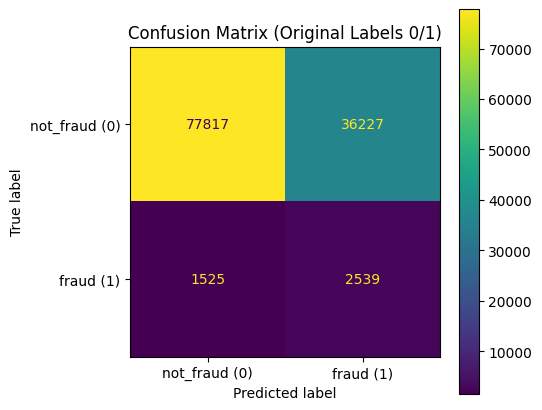

In [ ]:
def evaluate(model, X_te, y_te, threshold):
    scores = anomaly_score(model, X_te)  # higher = more anomalous (fraud-like)
    y_pred = (scores >= threshold).astype(int)

    pos_rate = float(np.mean(y_pred))
    rec  = recall_score(y_te, y_pred, zero_division=0)
    prec = precision_score(y_te, y_pred, zero_division=0)
    f1   = f1_score(y_te, y_pred, zero_division=0)
    roc  = roc_auc_score(y_te, scores)
    pr   = average_precision_score(y_te, scores)

    print(f"[TEST] pos_rate={pos_rate*100:.2f}% (prevalence={float(np.mean(y_te))*100:.2f}%)")
    print(f"[TEST] Recall(fraud=1): {rec:.4f} | Precision: {prec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f}")
    print("\nClassification report (positive=fraud=1):")
    print(classification_report(y_te, y_pred, digits=4, zero_division=0, target_names=["not_fraud(0)", "fraud(1)"]))

    fig, ax = plt.subplots(figsize=(5, 5))
    ConfusionMatrixDisplay.from_predictions(
        y_te, y_pred,
        labels=[0, 1],
        display_labels=["not_fraud (0)", "fraud (1)"],
        ax=ax
    )
    ax.set_title("Confusion Matrix (Original Labels 0/1)")
    plt.show()

    return {"recall": rec, "precision": prec, "f1": f1, "roc_auc": roc, "pr_auc": pr}

test_metrics = evaluate(final_model, X_test, y_test, threshold=best_threshold)


PermutationExplainer explainer: 801it [11:21,  1.16it/s]
/tmp/ipython-input-939403058.py:24: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(vals, X_explain, show=False)


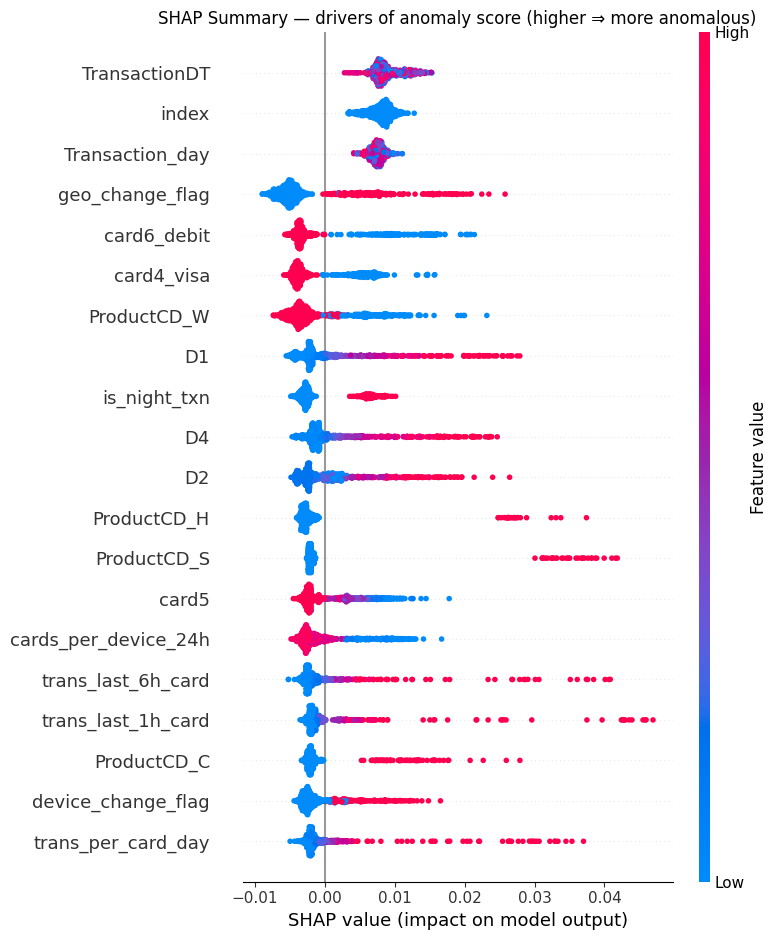

SHAP summary saved to: /content/drive/MyDrive/RThesis/shap_summary_iforest.png


In [ ]:
# Choose small background and explanation samples for performance
BACKGROUND_ROWS = min(200, len(X_train))
EXPLAIN_ROWS = min(800, len(X_test))

bg = X_train.sample(BACKGROUND_ROWS, random_state=SEED)
X_explain = X_test.sample(EXPLAIN_ROWS, random_state=SEED)

# Model scoring function: higher = more anomalous
def score_fn(X):
    return anomaly_score(final_model, pd.DataFrame(X, columns=X_train.columns))

# Try TreeExplainer first (may or may not work with IF), else fall back to KernelExplainer
try:
    explainer = shap.Explainer(score_fn, bg)  # auto-selects a method; often Kernel for callable
    shap_values = explainer(X_explain)
    vals = shap_values.values
except Exception as e:
    print("Falling back to KernelExplainer due to:", repr(e))
    explainer = shap.KernelExplainer(score_fn, bg)
    shap_values = explainer.shap_values(X_explain, nsamples=100)
    vals = shap_values  # already an array

plt.figure()
shap.summary_plot(vals, X_explain, show=False)
plt.title("SHAP Summary — drivers of anomaly score (higher ⇒ more anomalous)")
plt.tight_layout()
shap_out_path = os.path.join(datapath, "shap_summary_iforest.png")
plt.savefig(shap_out_path, dpi=150)
plt.show()
print(f"SHAP summary saved to: {shap_out_path}")


In [ ]:
ART_DIR = datapath
os.makedirs(ART_DIR, exist_ok=True)

with open(os.path.join(ART_DIR, "iforest_best_params.json"), "w") as f:
    json.dump(study.best_params, f, indent=2)

with open(os.path.join(ART_DIR, "iforest_threshold_and_metrics.json"), "w") as f:
    json.dump({
        "global_threshold": best_threshold,
        "validation_stats": thr_stats,
        "test_metrics": test_metrics
    }, f, indent=2)

print("Saved:")
print("  Best params ->", os.path.join(ART_DIR, "iforest_best_params.json"))
print("  Threshold & metrics ->", os.path.join(ART_DIR, "iforest_threshold_and_metrics.json"))


Saved:
  Best params -> /content/drive/MyDrive/RThesis/iforest_best_params.json
  Threshold & metrics -> /content/drive/MyDrive/RThesis/iforest_threshold_and_metrics.json


In [ ]:
def build_oof_predictions(X, y, params, tscv, beta=2.0, min_precision=0.05):
    n_labeled = len(y)
    # Create a DataFrame for OOF predictions based on the labeled subset
    oof = pd.DataFrame({
        "row_id": np.arange(n_labeled),
        "y_true": y.values,
        "fold": -1,
        "has_oof": False,
        "anom_score": np.nan,
        "pred_label": np.nan,
        "threshold_used": np.nan
    })

    # Use only the labeled portion of X for cross-validation and OOF predictions
    X_labeled_subset = X.iloc[:n_labeled]

    for fold, (tr_idx, va_idx) in enumerate(tscv.split(X_labeled_subset), 1):
        X_tr, X_va = X_labeled_subset.iloc[tr_idx], X_labeled_subset.iloc[va_idx]
        y_va = y.iloc[va_idx]

        model = fit_iforest(X_tr, params)
        scores_va = anomaly_score(model, X_va)

        thr, stats = best_threshold_by_fbeta(y_va.values, scores_va, beta=beta, min_precision=min_precision)
        y_pred = (scores_va >= thr).astype(int)

        oof.loc[va_idx, "anom_score"] = scores_va
        oof.loc[va_idx, "pred_label"] = y_pred
        oof.loc[va_idx, "threshold_used"] = thr
        oof.loc[va_idx, "fold"] = fold
        oof.loc[va_idx, "has_oof"] = True

    oof["pred_label"] = oof["pred_label"].astype("Float64")
    return oof

# Note: X_train is passed here, but the function internally uses its labeled subset for CV
oof_df = build_oof_predictions(
    X=X_train, y=y_train, params=best_params, tscv=tscv,
    beta=BETA, min_precision=MIN_PRECISION
)

coverage = oof_df["has_oof"].mean()
print(f"OOF coverage (based on labeled data): {coverage:.2%}")

OOF_PATH = os.path.join(datapath, "oof_iforest.csv")
oof_df.to_csv(OOF_PATH, index=False)
print(f"Saved OOF predictions to: {OOF_PATH}")

OOF coverage (based on labeled data): 83.33%
Saved OOF predictions to: /content/drive/MyDrive/RThesis/oof_iforest.csv


In [ ]:
scores_train = anomaly_score(final_model, X_train)
pred_train = (scores_train >= best_threshold).astype(int)

train_pred_df = pd.DataFrame({
    "row_id": np.arange(len(X_train)),
    "y_true": y_train.values,
    "anom_score": scores_train,
    "pred_label": pred_train,
    "threshold_used": best_threshold
})

TRAIN_PRED_PATH = os.path.join(datapath, "train_predictions_iforest.csv")
train_pred_df.to_csv(TRAIN_PRED_PATH, index=False)
print(f"Saved training predictions to: {TRAIN_PRED_PATH}")


Saved training predictions to: /content/drive/MyDrive/RThesis/train_predictions_iforest.csv


In [ ]:
scores_test = anomaly_score(final_model, X_test)
pred_test = (scores_test >= best_threshold).astype(int)

test_pred_df = pd.DataFrame({
    "row_id": np.arange(len(X_test)),
    "y_true": y_test.values,
    "anom_score": scores_test,
    "pred_label": pred_test,
    "threshold_used": best_threshold
})

TEST_PRED_PATH = os.path.join(datapath, "test_predictions_iforest.csv")
test_pred_df.to_csv(TEST_PRED_PATH, index=False)
print(f"Saved test predictions to: {TEST_PRED_PATH}")


Saved test predictions to: /content/drive/MyDrive/RThesis/test_predictions_iforest.csv
